In [5]:
import os
import sys
import glob
import zipfile
import re
from lxml import etree
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline

In [6]:
class Archive(object):
    def __init__(self, path):
        self.zip = zipfile.ZipFile(path)
        self.filenames = [entry.filename for entry in self.zip.infolist()]
        book_pattern = re.compile('([0-9]*)_metadata\.xml')
        page_pattern = re.compile('ALTO\/([0-9]*)_([0-9]*)_([0-9]*)\.xml')
        page_pattern_2 = re.compile('ALTO\/([0-9]*)_([0-9]*)\.xml')
        bookmatches=filter(None, [ book_pattern.match(name) for name in self.filenames ])
        pagematches=filter(None, [ page_pattern.match(name) for name in self.filenames ])
        if not pagematches:
                pagematches=filter(None, [ page_pattern_2.match(name) for name in self.filenames ])
        self.book_codes={ match.group(1) : [] for match in bookmatches }
        self.vol_codes={ match.group(1) : [] for match in bookmatches }
        for match in pagematches:
            page_position=len(match.groups())
            #self.book_codes[ match.group(1) ].append(match.group(2))
            self.book_codes[ match.group(1) ].append(match.group(page_position))
            if page_position > 2:
                self.vol_codes[ match.group(1) ].append(match.group(page_position -1))
        
           
        
            
    def metadata_file(self, book_code):
        return self.zip.open(book_code + '_metadata.xml')
    
    def page_file(self, book_code,  page, vol_code):
        return self.zip.open('ALTO/' + book_code + '_' + vol_code + '_' + page + '.xml')
    
    def page_file_2(self, book_code, page):
        return self.zip.open('ALTO/' + book_code + '_' +page + '.xml')
    
    def __getitem__(self, index):
        return Book(self.book_codes.keys()[index],self)

In [7]:
class PageElement(object):
    def __init__(self, element):
        self.x=int(element.get('HPOS'))
        self.y=int(element.get('VPOS'))
        self.width=int(element.get('WIDTH'))
        self.height=int(element.get('HEIGHT'))
        self.text=element.get('CONTENT')
      
        
    def bbox(self):
        return dict(
            x=self.x,
            y=self.y,
            width=self.width,
            height=self.height,
            alpha=0.1
        )

In [8]:
class Page(object):
    def __init__(self, source):
        self.tree=etree.parse(source)
        self.element=self.query('//Page')[0]
        self.width=int(self.element.get('WIDTH'))
        self.height=int(self.element.get('HEIGHT'))
        self.elements=[PageElement(el) for el in self.query('//String')]
       
        
    def query(self, query):
        return self.tree.xpath(query)
    
    def content(self):
        return ' '.join(self.query('//*/@CONTENT'))
    
    def reconstruct(self, figure):
        axes=figure.add_subplot(1, 1, 1, xlim=[0, self.width], ylim=[self.height, 0], aspect='equal')
        for element in self.elements:
            ebox=element.bbox()
            ebox['transform']=axes.transData
            # first, render a text patch
            text=axes.text(element.x,element.y,element.text, verticalalignment='top', 
                    horizontalalignment='left')
                    #fontsize=font_scaling,bbox=box)
            # then, determine its bbox in data units
            renderer = figure.canvas.get_renderer()
            tbox=text.get_window_extent(renderer).transformed(axes.transData.inverted())
            # then, change the fontsize to match its true bbox
            theight=-1.0*tbox.height
            text.set_fontsize(ebox['height']*text.get_fontsize()/theight)
            # and update the bbox
            text.set_transform(ebox['transform'])


In [9]:
class Book(object):
    def __init__(self, code, archive):
        self.namespaces= {
            "mods":'http://www.loc.gov/mods/v3',
            "mets":'http://www.loc.gov/METS/'
        }
        self.archive = archive
        self.code = code
        self.metadata=archive.metadata_file(code)
        self.tree = etree.parse(self.metadata)
        self.title=self.query('//mods:title/text()')[0]
        self.page_codes = sorted(archive.book_codes[code], key=int)
        if archive.vol_codes[code]: 
            self.vol_codes = archive.vol_codes[code][0]
            print "self.vol_codes", self.vol_codes
      
        
    def query(self, query):
        return self.tree.xpath(query, namespaces=self.namespaces)
    
    def __getitem__(self, index):
        try:
            return Page(self.archive.page_file(self.code, self.page_codes[index], self.vol_codes))
        except:
            return Page(self.archive.page_file_2(self.code, self.page_codes[index]))
    
    def __iter__(self):
        for page_code in self.page_codes:
            yield Page(self.archive.page_file(self.code, page_code))

In [10]:
class Corpus(object):
    def __init__(self, zip_paths):
        self.paths=zip_paths
       
        
    def __iter__(self):
 
        for path in self.paths:
            
            archive=Archive(path)
            for book in archive.book_codes:
                yield Book(book, archive)
                
    def __getitem__(self, index):
       
        #return Archive(self.paths[index])
        return Archive(self.paths)

In [11]:
zips='/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/'


data_paths=glob.glob(os.path.join(zips)+'*')

#zips='/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/003998482_1_1-272pgs__675037_dat.zip'

#zips='/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/000206133_0_1-1178pgs__1023547_dat.zip3'

#corp=Corpus(data_paths[0])

/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/003998482_1_1-272pgs__675037_dat.zip
self.vol_codes 01
/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/000962896_0_1-56pgs__999275_dat.zip
/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/000304491_0_1-264pgs__663415_dat.zip
/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/003360082_0_1-32pgs__583120_dat.zip
/Users/rosafilgueira/EPCC/ATI-SE/Humanities/cluster-code/bluclobber/test/fixtures/corpus24/000566867_2_1-676pgs__607064_dat.zip
self.vol_codes 02


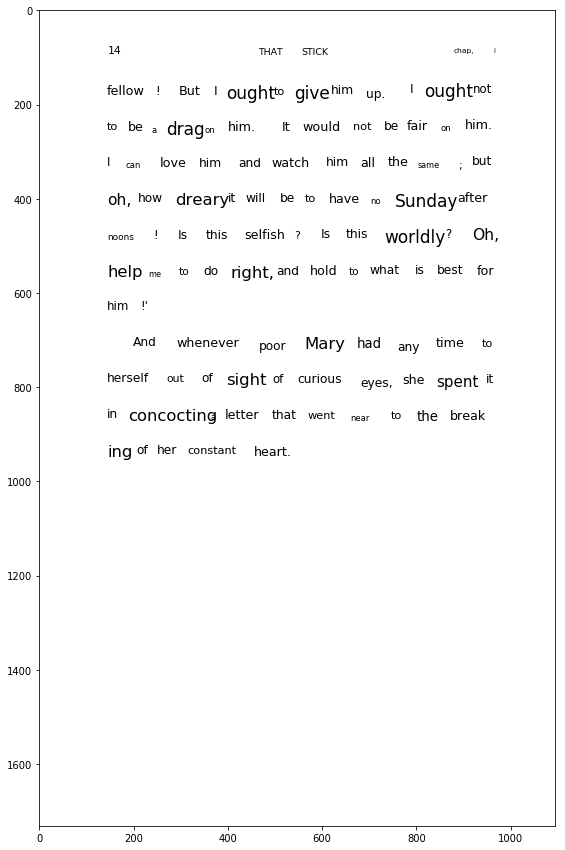

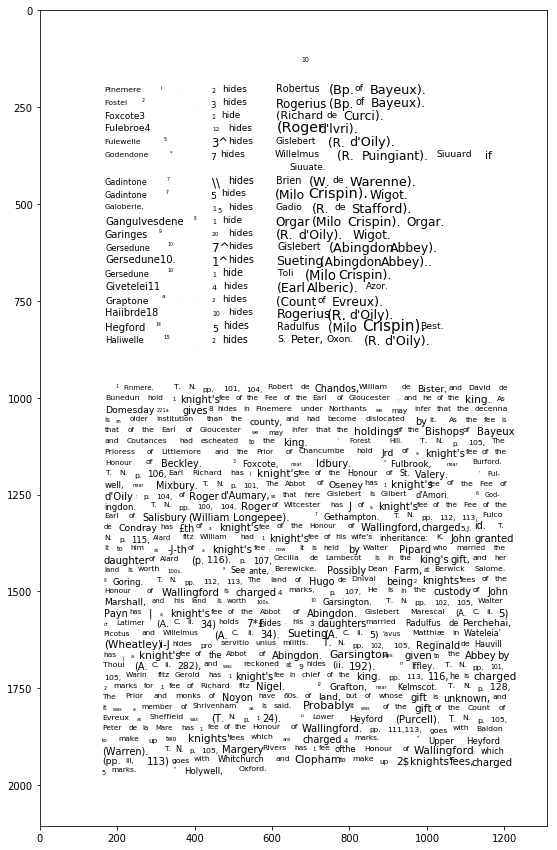

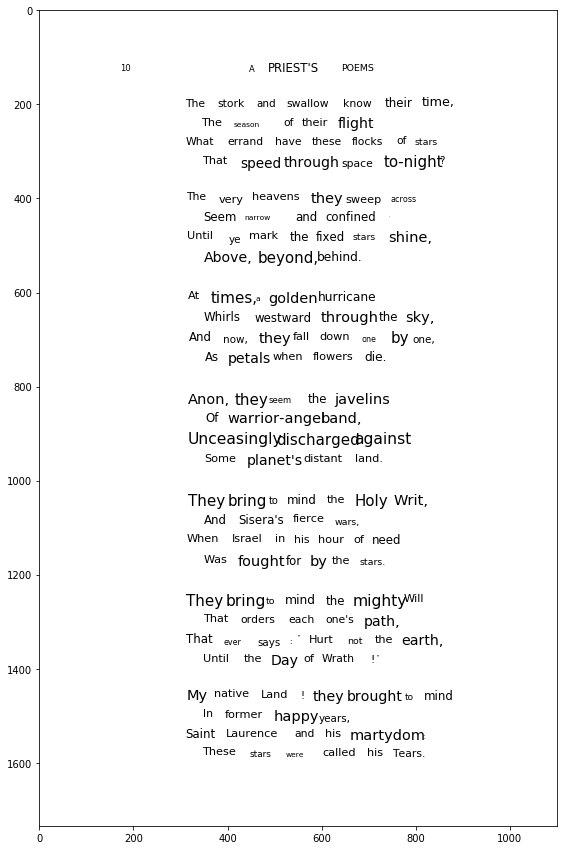

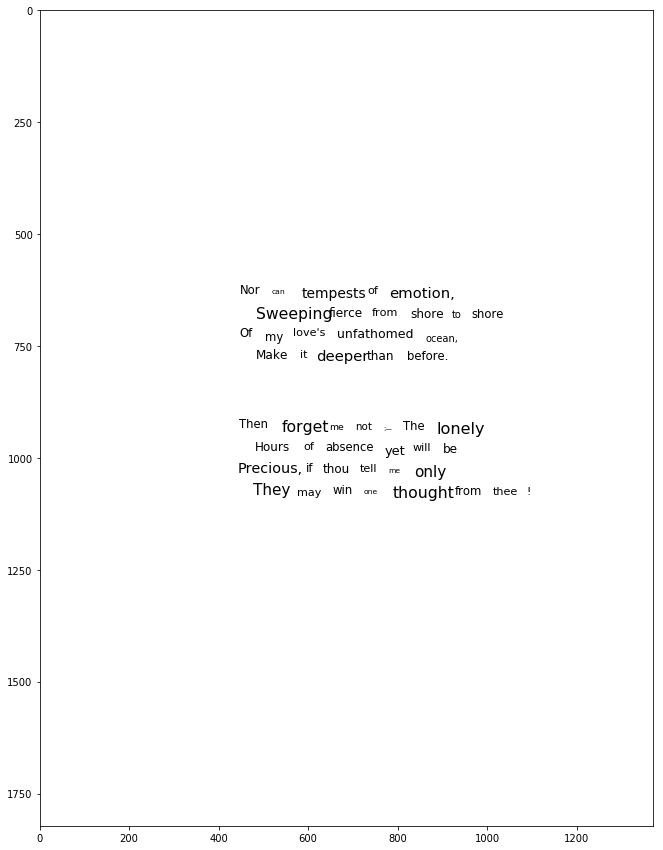

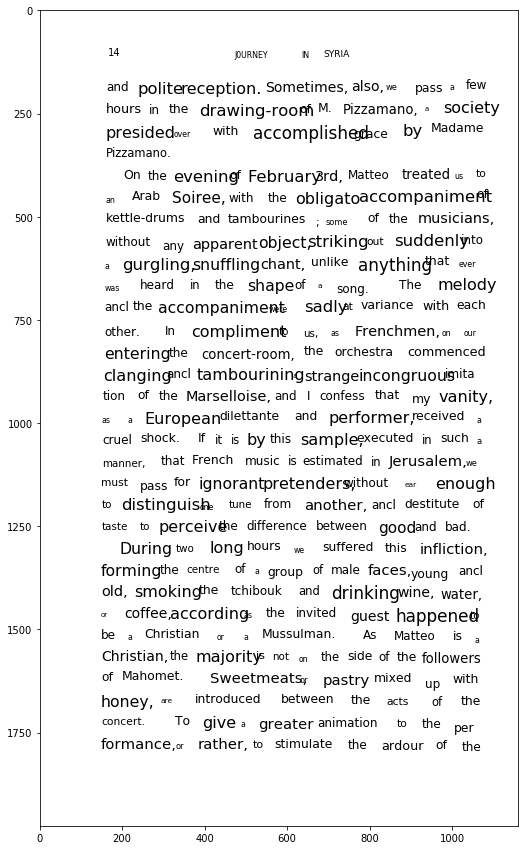

In [12]:
for corp_i in data_paths[:5]:
    print corp_i
    corp= Corpus(corp_i)

    fig=figure(figsize=[20,15])

    corp[0][0][25].reconstruct(fig)